In [2]:
"""
structure of data folder
data/labels/ all xml files
data/tablemask/all tablemasks/
data/image all images
"""

'\nstructure of data folder\ndata/labels/ all xml files\ndata/tablemask/all tablemasks/\ndata/image all images\n'

In [3]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 2.3.0
Default GPU Device: /device:GPU:0


In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input, Concatenate, UpSampling2D

In [5]:
import cv2

In [6]:
img_height, img_width = 256, 256

def normalize(input_image):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image


def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img,channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def decode_mask_img(img):
  # convert the compressed string to a 2D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=1)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])



In [7]:
class TableNet:
  @staticmethod
  def build_table_decoder(inputs, pool3, pool4):
    x = Conv2D(512, (1, 1), activation = 'relu', name='conv7_table')(inputs)
    x = UpSampling2D(size=(2, 2))(x)

    concatenated = Concatenate()([x, pool4])

    # concatenated = concatenate([x, pool4])

    x = UpSampling2D(size=(2,2))(concatenated)
    
    concatenated = Concatenate()([x, pool3])

    x = UpSampling2D(size=(2,2))(concatenated)
    x = UpSampling2D(size=(2,2))(x)

    last = tf.keras.layers.Conv2DTranspose(
      3, 3, strides=2,
      padding='same', name='table_output') 
    
    x = last(x)

    return x

  @staticmethod
  def build_column_decoder(inputs, pool3, pool4):
    
    x = Conv2D(512, (1, 1), activation = 'relu', name='block7_conv1_column')(inputs)
    x = Dropout(0.8, name='block7_dropout_column')(x)

    x = Conv2D(512, (1, 1), activation = 'relu', name='block8_conv1_column')(x)
    x = UpSampling2D(size=(2, 2))(x)

    concatenated = Concatenate()([x, pool4])

    # concatenated = concatenate([x, pool4])

    x = UpSampling2D(size=(2,2))(concatenated)
    
    concatenated = Concatenate()([x, pool3])

    x = UpSampling2D(size=(2,2))(concatenated)
    x = UpSampling2D(size=(2,2))(x)

    last = tf.keras.layers.Conv2DTranspose(
      3, 3, strides=2,
      padding='same', name='column_output') 
    
    x = last(x)

    return x  

  @staticmethod
  def vgg_base(inputs):
    base_model = tf.keras.applications.vgg19.VGG19(
        input_shape=[256, 256, 3],
        include_top=False, weights='imagenet')
    
    layer_names = ['block3_pool', 'block4_pool', 'block5_pool']
    layers = [base_model.get_layer(name).output for name in layer_names]

    pool_layers_model = Model(inputs=base_model.input, outputs=layers, name='VGG-19')
    pool_layers_model.trainable = False

    return pool_layers_model(inputs)
  
  @staticmethod
  def build():
    inputShape = (256, 256, 3)

    inputs = Input(shape=inputShape, name='input')

    pool_layers = TableNet.vgg_base(inputs)

    x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv1')(pool_layers[2])
    x = Dropout(0.8, name='block6_dropout1')(x)
    x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv2')(x)
    x = Dropout(0.8, name = 'block6_dropout2')(x)
    
    table_mask = TableNet.build_table_decoder(x, pool_layers[0], pool_layers[1])
    #column_mask = TableNet.build_column_decoder(x, pool_layers[0], pool_layers[1])

    model = Model(
              inputs=inputs,
                    outputs=[table_mask],
                    name="tablenet")
    
    return model

In [8]:
model = TableNet.build()

In [9]:
losses = {
    "table_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    #,column_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
}
lossWeights = {"table_output": 1.0
               #, "column_output": 1.0
              }

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08),
              loss=losses,
              metrics=['accuracy'],
              loss_weights=lossWeights)
model.summary()

Model: "tablenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
VGG-19 (Functional)             [(None, 32, 32, 256) 20024384    input[0][0]                      
__________________________________________________________________________________________________
block6_conv1 (Conv2D)           (None, 8, 8, 512)    262656      VGG-19[0][2]                     
__________________________________________________________________________________________________
block6_dropout1 (Dropout)       (None, 8, 8, 512)    0           block6_conv1[0][0]               
___________________________________________________________________________________________

In [10]:
list_ds = tf.data.Dataset.list_files('data/labels/*.xml',shuffle=False)
list_ds1 = tf.data.Dataset.list_files('data/labels/*.xml')

In [11]:
type(list_ds)


def p(file_path):
    file_path = tf.strings.regex_replace(file_path, '.xml', '.PNG')
    file_path = tf.strings.regex_replace(file_path, 'labels', 'images')
    img = normalize(decode_img(tf.io.read_file(file_path)))
    print(file_path)
    return img
def q(file_path):
    file_path = tf.strings.regex_replace(file_path, '.xml', '.jpeg')
    file_path = tf.strings.regex_replace(file_path, 'labels', 'tablemask')
    img = normalize(decode_mask_img(tf.io.read_file(file_path)))    
    print(file_path)
    return img

def r(file_path):
    img=p(file_path)
    tbmask=q(file_path)
    
    return img,{'table_output':tbmask}
    

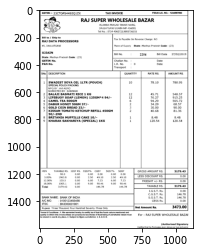

In [12]:
im=cv2.imread('data/binary/00001.PNG')
plt.imshow(im)

In [13]:
dataset=list_ds.map(r)
#dataset2=list_ds.map(q)

Tensor("StaticRegexReplace_1:0", shape=(), dtype=string)
Tensor("StaticRegexReplace_3:0", shape=(), dtype=string)


In [15]:

DATASET_SIZE = len(list(list_ds))
train_size = int(0.8 * DATASET_SIZE)
test_size = int(0.2* DATASET_SIZE)
#train_size=250
train = dataset.take(train_size)
test = dataset.skip(train_size)
TRAIN_LENGTH = len(list(train))
BUFFER_SIZE = 1000

In [17]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'Table Mask' 
  ]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()




(256, 256, 3)


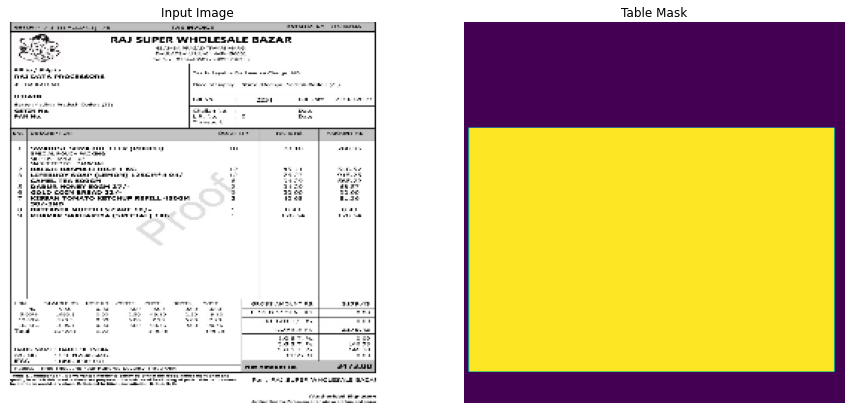

(256, 256, 3)


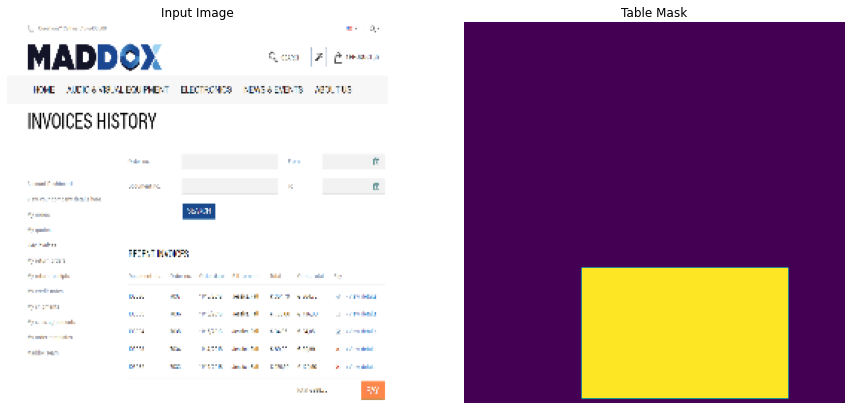

In [18]:
for image,mask in train.take(2):
  print(image.shape)
  # print(mask.shape)
  display([image, mask['table_output'] #, mask['column_output']
           ])

In [19]:
BATCH_SIZE =1
train_dataset = train.batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [20]:
#model.load_weights('models/mymodel_1.h5')
#%load_ext tensorboard
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [21]:
#model.load_weights('mymodel_1.h5')
%reload_ext tensorboard
%tensorboard --logdir logs/fit    

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 11684.

In [22]:
from IPython.display import clear_output
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        #show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath="models/mymodel_{epoch}.h5",
        save_best_only=True,
        monitor="val_loss",
        verbose=1,
)

early_stoping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        verbose=1,
)

In [23]:

#model.load_weights('model_67.h5')

with tf.device("/gpu:0"):
    EPOCHS =1000
    VAL_SUBSPLITS = 5
    STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
    VALIDATION_STEPS = test_size//BATCH_SIZE//VAL_SUBSPLITS
    STEPS_PER_EPOCH=10

    model_history = model.fit(train_dataset,epochs=EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_dataset,
                              callbacks=[DisplayCallback(), model_checkpoint,tensorboard_callback],
                              use_multiprocessing=True
                             )


Sample Prediction after epoch 497


Epoch 00497: val_loss did not improve from 0.32220
10/10 [==============================] - 5s 477ms/step - loss: 0.4409 - accuracy: 0.8039 - val_loss: 0.3531 - val_accuracy: 0.8522
Epoch 498/1000
 7/10 [====================>.........] - ETA: 0s - loss: 0.4242 - accuracy: 0.8020

KeyboardInterrupt: 

In [24]:
history=model_history

NameError: name 'model_history' is not defined

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
def create_mask(pred_mask1):
  pred_mask1 = tf.argmax(pred_mask1, axis=-1)
  pred_mask1 = pred_mask1[..., tf.newaxis]
  return pred_mask1[0]

for image, mask in train_dataset.take(1):
  sample_image, sample_mask1= image, mask['table_output']

def show_predictions(dataset=None, num=1):
  if dataset:
    for image,mask1 in dataset.take(num):
        pred_mask1 = model.predict(image, verbose=1)
        table_mask= create_mask(pred_mask1)
      
        display([image[0], table_mask])
  else:
    pred_mask1= model.predict(sample_image, verbose=1)
    table_mask= create_mask(pred_mask1)
    display([sample_image[0], table_mask])


(256, 256, 3)
(1, 256, 256, 1)
(1, 256, 256, 3)


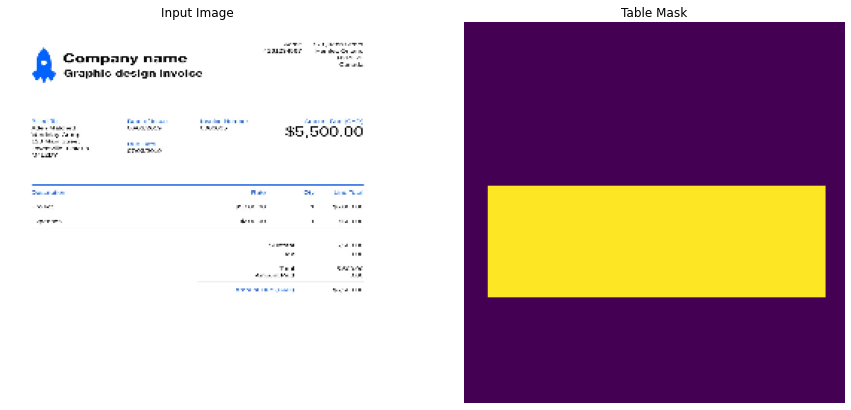

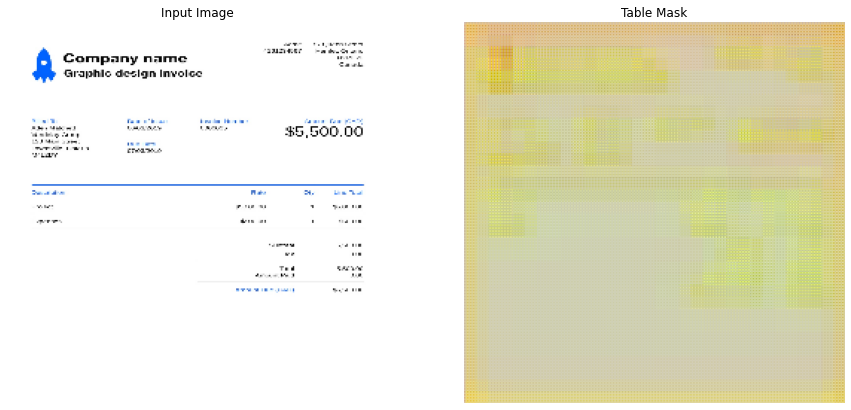

In [26]:
import numpy as np
for image,mask in test_dataset.take(1):
  #image[0]=img
  #image=np.array(img)
  print(image[0].shape)
  print(mask['table_output'].shape)

  mask2=model.predict(image)
  print(mask2.shape)
  # print(mask.shape)
  display([image[0], mask['table_output'][0] #, mask['column_output']
           ])
  display([image[0], mask2[0] #, mask['column_output']
          ])

In [ ]:
#model.save('binarymodel_1.h5')

1/1 [==============================] - 0s 41ms/step


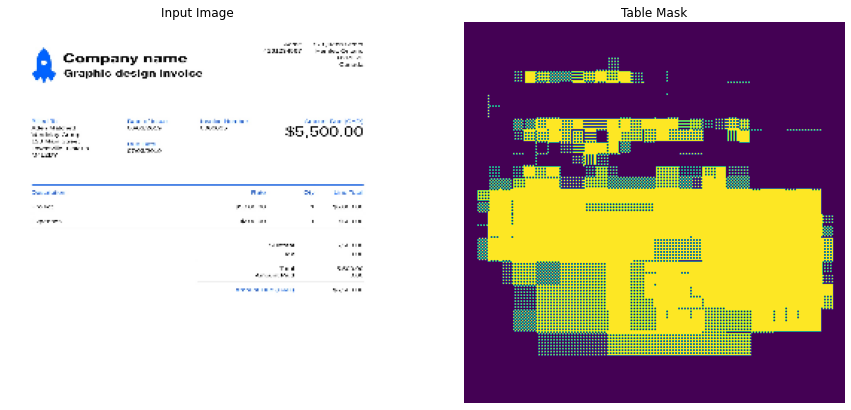

1/1 [==============================] - 0s 41ms/step


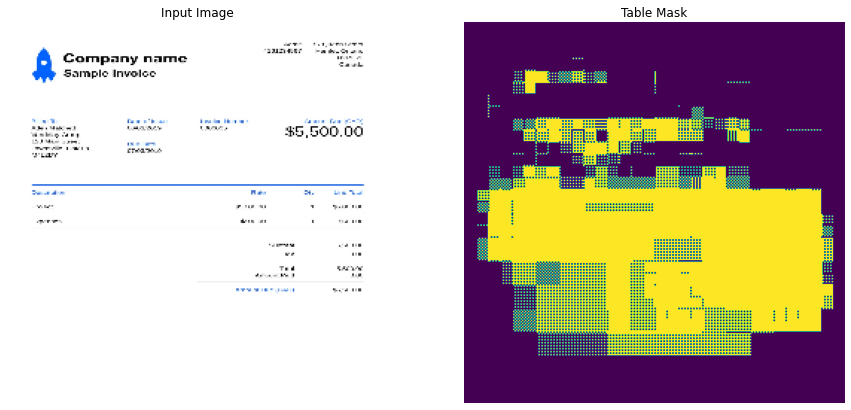

1/1 [==============================] - 0s 41ms/step


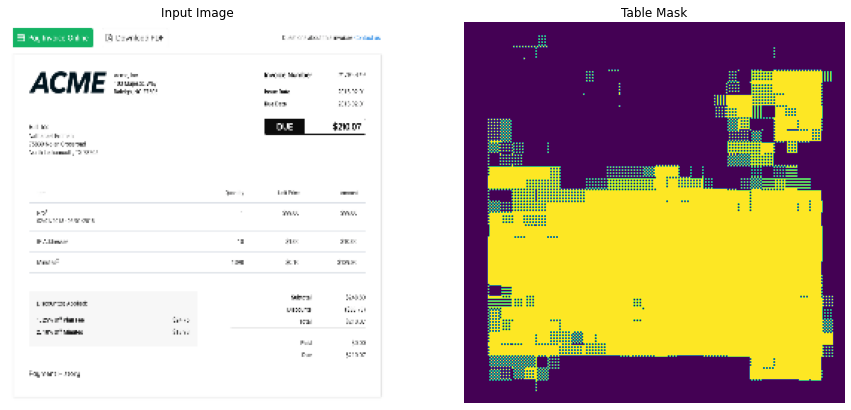

1/1 [==============================] - 0s 38ms/step


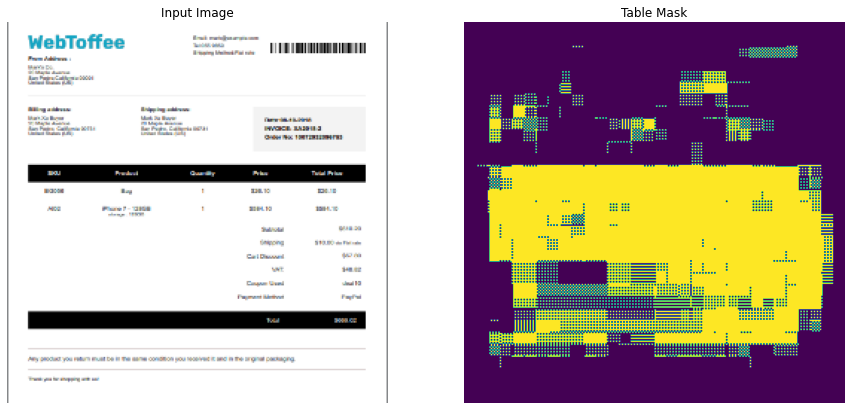

1/1 [==============================] - 0s 41ms/step


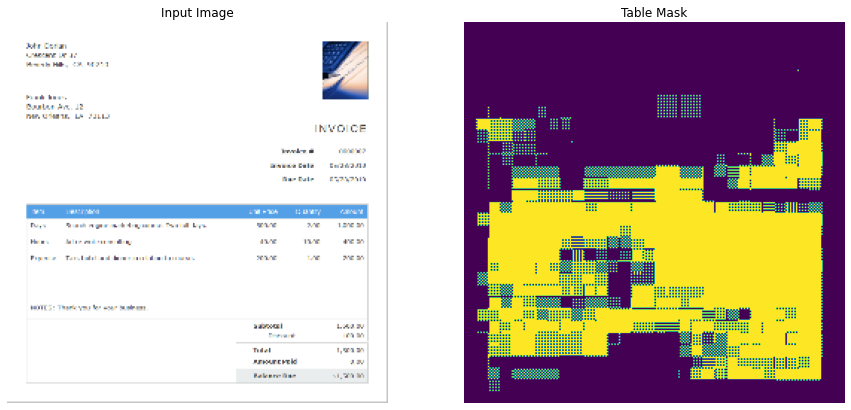

1/1 [==============================] - 0s 41ms/step


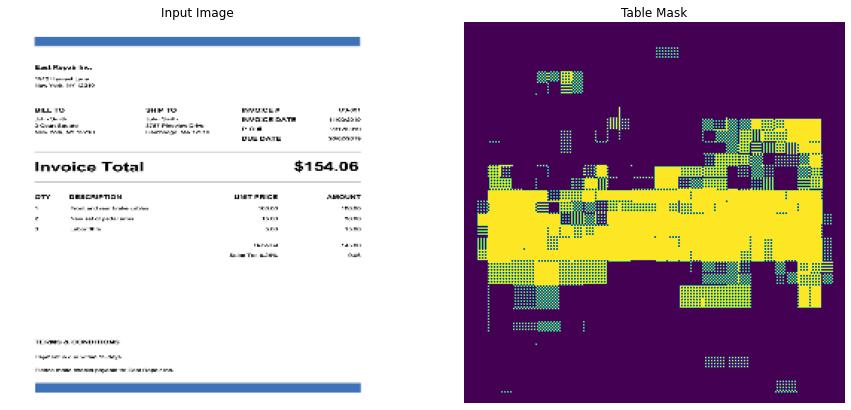

In [27]:
show_predictions(test_dataset, 6)

In [47]:
import os
import cv2
#from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops
from skimage.util import montage as montage

In [48]:
from skimage.segmentation import mark_boundaries


In [49]:
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

In [50]:
from skimage.morphology import label
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list, all_masks=None):
    # Take the individual ship masks and create a single mask array for all ships
    if all_masks is None:
        all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

1/1 [==============================] - 0s 40ms/step


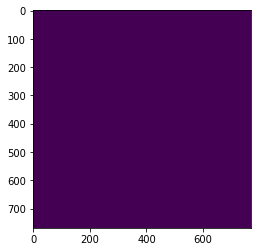

In [51]:
for image,mask1 in test_dataset.take(1):
        im=image
        pred_mask1 = model.predict(image, verbose=1)
        table_mask= create_mask(pred_mask1)
        plt.imshow(masks_as_image(pred_mask1))

In [ ]:
plt.imshow(masks_as_image(pred_mask1))

In [28]:
image=cv2.imread('data/images/00001.PNG')

In [45]:
im=cv2.resize(image,(256,256))

In [43]:
im=np.reshape(im,(model.input_shape))

TypeError: 'NoneType' object cannot be interpreted as an integer

In [46]:
p=model.predict(im)

ValueError: in user code:

    C:\Users\Abhishek pandir\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\Abhishek pandir\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Abhishek pandir\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Abhishek pandir\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Abhishek pandir\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Abhishek pandir\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Users\Abhishek pandir\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Users\Abhishek pandir\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\Abhishek pandir\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    C:\Users\Abhishek pandir\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\Abhishek pandir\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\Abhishek pandir\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    C:\Users\Abhishek pandir\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\Abhishek pandir\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\Users\Abhishek pandir\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\input_spec.py:196 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer block1_conv1 is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: [32, 256, 3]


In [30]:
model.input_shape

(None, 256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


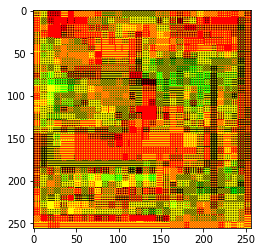

In [42]:
plt.imshow(p[0][:,:])

In [52]:
from tablenet.tablenet import TableNet